# Medical Q&A Assistant - Hallucination Detection and Analysis

## Setup and Environment Configuration

In [1]:
# Cell 1: Install required packages
!pip install -q transformers torch numpy pandas matplotlib tqdm colorama scikit-learn seaborn


In [2]:
# Cell 2: Import necessary libraries
import os
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from colorama import Fore, Style
import logging
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


## Load Evaluation Results

In [3]:
# Cell 3: Load evaluation results
def load_results(file_path="evaluation/output_logs.json"):
    """Load evaluation results from file"""
    try:
        with open(file_path, "r") as f:
            results = json.load(f)
        logger.info(f"Loaded results from {file_path}")
        return results
    except FileNotFoundError:
        logger.error(f"Results file not found: {file_path}")
        return None
    except json.JSONDecodeError:
        logger.error(f"Invalid JSON format in results file: {file_path}")
        return None

# Load results
results = load_results()

if results is None:
    logger.warning("No results found. Creating sample data for demonstration.")
    # Create sample results for demonstration
    results = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "model": "Qwen/Qwen1.5-4B-Chat",
        "responses": [],
        "hallucinations": []
    }
    
    # Sample queries
    sample_queries = [
        {
            "id": 1,
            "query": "What are the early symptoms of diabetes?",
            "category": "Symptom Explanation",
            "expected_concepts": ["polyuria", "polydipsia", "weight loss", "fatigue", "blurred vision"]
        },
        {
            "id": 2,
            "query": "Explain what hypertension means in simple terms",
            "category": "Medical Term Simplification",
            "expected_concepts": ["high blood pressure", "heart", "blood vessels", "systolic", "diastolic"]
        },
        {
            "id": 3,
            "query": "Should I be worried about chest pain?",
            "category": "General Health Guidance",
            "expected_concepts": ["emergency", "heart attack", "seek medical attention", "warning signs"]
        },
        {
            "id": 4,
            "query": "What causes frequent headaches?",
            "category": "Symptom Explanation",
            "expected_concepts": ["stress", "dehydration", "eyestrain", "migraine", "tension"]
        },
        {
            "id": 5,
            "query": "When should someone see a cardiologist?",
            "category": "General Health Guidance",
            "expected_concepts": ["heart disease", "symptoms", "risk factors", "referral", "specialist"]
        }
    ]
    
    # Create sample responses with hallucinations
    prompt_types = ["zero_shot", "few_shot", "cot", "meta"]
    
    for query_data in sample_queries:
        query_results = {
            "query_id": query_data["id"],
            "query": query_data["query"],
            "category": query_data["category"],
            "responses": {}
        }
        
        for prompt_type in prompt_types:
            # Generate random hallucination data for demonstration
            hallucination_score = np.random.uniform(0, 5)
            hallucination_issues = []
            
            if hallucination_score > 2:
                possible_issues = [
                    "Definitive claim detected: '100% effective'",
                    "Specific unverifiable statistic: '87% of patients'",
                    "Unverifiable claim: 'doctors agree that'",
                    "Medical advice detected: 'you should take'"
                ]
                
                # Add 1-3 random issues
                num_issues = np.random.randint(1, 4)
                for _ in range(num_issues):
                    issue = np.random.choice(possible_issues)
                    if issue not in hallucination_issues:
                        hallucination_issues.append(issue)
            
            query_results["responses"][prompt_type] = {
                "prompt": f"Sample {prompt_type} prompt for {query_data['query']}",
                "response": f"Sample response using {prompt_type} for {query_data['query']}",
                "hallucination_score": hallucination_score,
                "hallucination_issues": hallucination_issues,
                "hallucination_severity": "Low" if hallucination_score < 2 else "Medium" if hallucination_score < 3.5 else "High"
            }
            
            # Add to hallucinations list if score is high enough
            if hallucination_score > 3:
                results["hallucinations"].append({
                    "query_id": query_data["id"],
                    "query": query_data["query"],
                    "prompt_type": prompt_type,
                    "response_excerpt": f"Sample response excerpt for {query_data['query']}",
                    "issues": hallucination_issues,
                    "score": hallucination_score
                })
        
        results["responses"].append(query_results)

# Extract hallucinations from results if not already present
if "hallucinations" not in results:
    results["hallucinations"] = []
    
    for query_result in results["responses"]:
        query_id = query_result["query_id"]
        query = query_result["query"]
        
        for prompt_type, response_data in query_result["responses"].items():
            hallucination_score = response_data.get("hallucination_score", 0)
            hallucination_issues = response_data.get("hallucination_issues", [])
            
            if hallucination_score > 3:
                results["hallucinations"].append({
                    "query_id": query_id,
                    "query": query,
                    "prompt_type": prompt_type,
                    "response_excerpt": response_data.get("response", "")[:200] + "...",
                    "issues": hallucination_issues,
                    "score": hallucination_score
                })

print(f"Loaded data with {len(results['hallucinations'])} identified hallucinations")


2025-06-23 20:49:41,981 - INFO - Loaded results from evaluation/output_logs.json


Loaded data with 0 identified hallucinations


## Hallucination Detection Implementation

In [4]:
# Cell 4: Hallucination detection function
def detect_hallucinations(response, query, expected_concepts=None):
    """
    Detect potential hallucinations in model responses
    Returns a hallucination score and flagged issues
    """
    hallucination_indicators = {
        "definitive_claims": [
            r"100% effective", r"always works", r"cures all", r"completely safe",
            r"guaranteed to", r"never causes", r"all patients", r"everyone with"
        ],
        "specific_numbers": [
            r"\d{2,3}% of (patients|people|cases)", r"studies show \d{2,3}%"
        ],
        "unverifiable_claims": [
            r"recent studies show", r"doctors agree that", r"research has proven",
            r"it is well established", r"it is widely accepted"
        ],
        "medical_advice": [
            r"you should", r"you must", r"you need to", r"I recommend",
            r"take \d+ (mg|milligrams)", r"increase your dosage", r"reduce your dosage"
        ]
    }
    
    issues = []
    hallucination_score = 0
    
    # Check for definitive claims
    for pattern in hallucination_indicators["definitive_claims"]:
        if re.search(pattern, response, re.IGNORECASE):
            issues.append(f"Definitive claim detected: '{re.search(pattern, response, re.IGNORECASE).group(0)}'")
            hallucination_score += 2
    
    # Check for specific unverifiable numbers
    for pattern in hallucination_indicators["specific_numbers"]:
        if re.search(pattern, response, re.IGNORECASE):
            issues.append(f"Specific unverifiable statistic: '{re.search(pattern, response, re.IGNORECASE).group(0)}'")
            hallucination_score += 1.5
    
    # Check for unverifiable claims
    for pattern in hallucination_indicators["unverifiable_claims"]:
        if re.search(pattern, response, re.IGNORECASE):
            issues.append(f"Unverifiable claim: '{re.search(pattern, response, re.IGNORECASE).group(0)}'")
            hallucination_score += 1
    
    # Check for medical advice
    for pattern in hallucination_indicators["medical_advice"]:
        if re.search(pattern, response, re.IGNORECASE):
            issues.append(f"Medical advice detected: '{re.search(pattern, response, re.IGNORECASE).group(0)}'")
            hallucination_score += 2
    
    # Check for expected concepts (if provided)
    if expected_concepts:
        found_concepts = 0
        for concept in expected_concepts:
            if concept.lower() in response.lower():
                found_concepts += 1
        
        concept_coverage = found_concepts / len(expected_concepts)
        if concept_coverage < 0.5:
            issues.append(f"Low coverage of expected medical concepts: {found_concepts}/{len(expected_concepts)}")
            hallucination_score += 1
    
    # Normalize score between 0-5
    normalized_score = min(5, hallucination_score / 2)
    
    return {
        "score": normalized_score,
        "issues": issues,
        "severity": "High" if normalized_score > 3.5 else "Medium" if normalized_score > 2 else "Low"
    }


## Hallucination Analysis

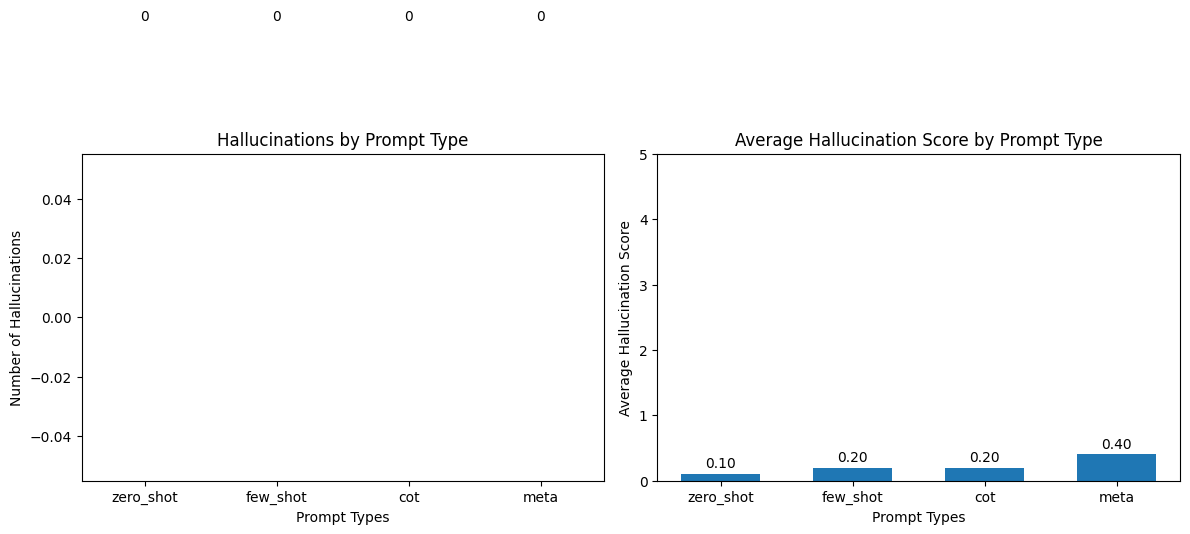

In [5]:
# Cell 5: Analyze hallucinations by prompt type
def analyze_hallucinations_by_prompt(results):
    """Analyze hallucinations by prompt type"""
    # Extract data
    prompt_types = list(results["responses"][0]["responses"].keys())
    
    # Count hallucinations by prompt type
    hallucination_counts = {pt: 0 for pt in prompt_types}
    hallucination_scores = {pt: [] for pt in prompt_types}
    
    for query_result in results["responses"]:
        for prompt_type in prompt_types:
            response_data = query_result["responses"][prompt_type]
            
            score = response_data.get("hallucination_score", 0)
            hallucination_scores[prompt_type].append(score)
            
            if score > 3:  # Consider high scores as hallucinations
                hallucination_counts[prompt_type] += 1
    
    # Calculate average hallucination scores
    avg_scores = {pt: sum(scores) / len(scores) for pt, scores in hallucination_scores.items()}
    
    return {
        "counts": hallucination_counts,
        "average_scores": avg_scores
    }

# Analyze hallucinations by prompt type
prompt_analysis = analyze_hallucinations_by_prompt(results)

# Visualize hallucinations by prompt type
plt.figure(figsize=(12, 6))

# Plot hallucination counts
prompt_types = list(prompt_analysis["counts"].keys())
x = np.arange(len(prompt_types))
counts = [prompt_analysis["counts"][pt] for pt in prompt_types]

plt.subplot(1, 2, 1)
plt.bar(x, counts, width=0.6)
plt.xlabel('Prompt Types')
plt.ylabel('Number of Hallucinations')
plt.title('Hallucinations by Prompt Type')
plt.xticks(x, prompt_types)

# Add value labels on top of bars
for i, v in enumerate(counts):
    plt.text(i, v + 0.1, str(v), ha='center')

# Plot average hallucination scores
avg_scores = [prompt_analysis["average_scores"][pt] for pt in prompt_types]

plt.subplot(1, 2, 2)
plt.bar(x, avg_scores, width=0.6)
plt.xlabel('Prompt Types')
plt.ylabel('Average Hallucination Score')
plt.title('Average Hallucination Score by Prompt Type')
plt.xticks(x, prompt_types)
plt.ylim(0, 5)

# Add value labels on top of bars
for i, v in enumerate(avg_scores):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig("evaluation/hallucination_by_prompt.png")
plt.show()


## Hallucination Issue Types Analysis

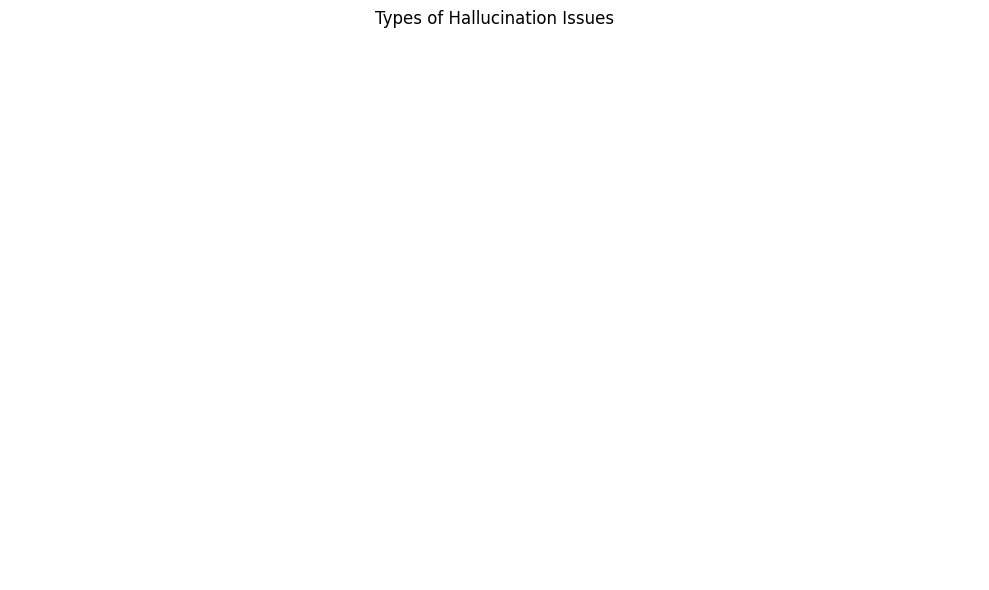

Hallucination Issue Counts:
- Definitive claim: 0
- Specific unverifiable statistic: 0
- Unverifiable claim: 0
- Medical advice: 0
- Low concept coverage: 0
- Other: 0


In [6]:
# Cell 6: Analyze hallucination issue types
def analyze_hallucination_issues(results):
    """Analyze types of hallucination issues"""
    # Extract all issues
    all_issues = []
    for hallucination in results["hallucinations"]:
        all_issues.extend(hallucination["issues"])
    
    # Categorize issues
    issue_types = {
        "Definitive claim": 0,
        "Specific unverifiable statistic": 0,
        "Unverifiable claim": 0,
        "Medical advice": 0,
        "Low concept coverage": 0,
        "Other": 0
    }
    
    for issue in all_issues:
        if "Definitive claim" in issue:
            issue_types["Definitive claim"] += 1
        elif "Specific unverifiable statistic" in issue:
            issue_types["Specific unverifiable statistic"] += 1
        elif "Unverifiable claim" in issue:
            issue_types["Unverifiable claim"] += 1
        elif "Medical advice" in issue:
            issue_types["Medical advice"] += 1
        elif "Low coverage of expected medical concepts" in issue:
            issue_types["Low concept coverage"] += 1
        else:
            issue_types["Other"] += 1
    
    return issue_types

# Analyze hallucination issue types
issue_types = analyze_hallucination_issues(results)

# Visualize issue types
plt.figure(figsize=(10, 6))

# Plot issue types
labels = list(issue_types.keys())
sizes = list(issue_types.values())

# Filter out zero values
non_zero_labels = [label for label, size in zip(labels, sizes) if size > 0]
non_zero_sizes = [size for size in sizes if size > 0]

plt.pie(non_zero_sizes, labels=non_zero_labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Types of Hallucination Issues')
plt.tight_layout()
plt.savefig("evaluation/hallucination_issues.png")
plt.show()

# Display issue counts
print("Hallucination Issue Counts:")
for issue_type, count in issue_types.items():
    print(f"- {issue_type}: {count}")


## Hallucination by Query Category

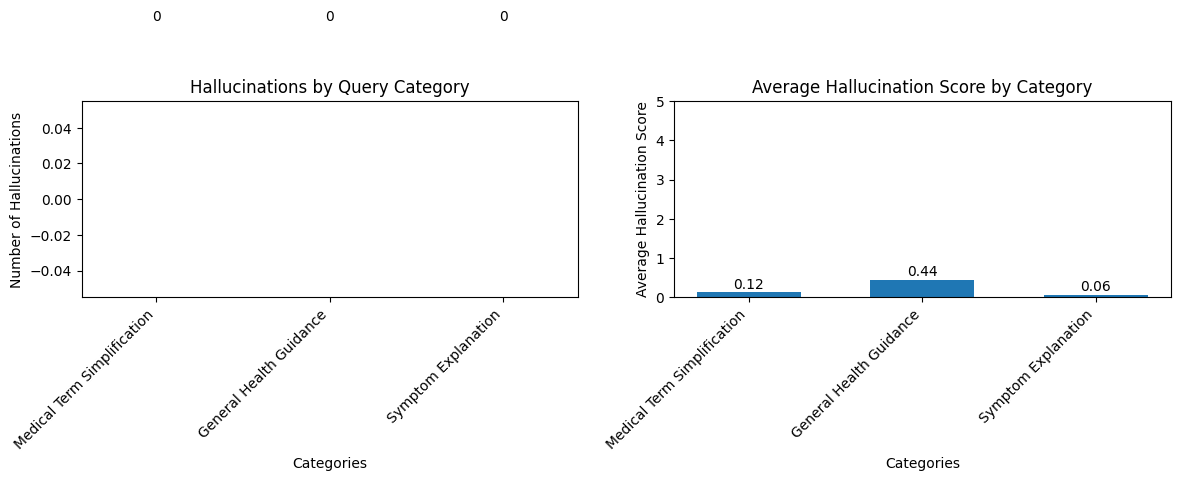

In [7]:
# Cell 7: Analyze hallucinations by query category
def analyze_hallucinations_by_category(results):
    """Analyze hallucinations by query category"""
    # Extract categories
    categories = list(set(q["category"] for q in results["responses"]))
    
    # Count hallucinations by category
    category_counts = {cat: 0 for cat in categories}
    category_scores = {cat: [] for cat in categories}
    
    for query_result in results["responses"]:
        category = query_result["category"]
        
        for prompt_type, response_data in query_result["responses"].items():
            score = response_data.get("hallucination_score", 0)
            category_scores[category].append(score)
            
            if score > 3:  # Consider high scores as hallucinations
                category_counts[category] += 1
    
    # Calculate average hallucination scores
    avg_scores = {cat: sum(scores) / len(scores) for cat, scores in category_scores.items()}
    
    return {
        "counts": category_counts,
        "average_scores": avg_scores
    }

# Analyze hallucinations by category
category_analysis = analyze_hallucinations_by_category(results)

# Visualize hallucinations by category
plt.figure(figsize=(12, 6))

# Plot hallucination counts
categories = list(category_analysis["counts"].keys())
x = np.arange(len(categories))
counts = [category_analysis["counts"][cat] for cat in categories]

plt.subplot(1, 2, 1)
plt.bar(x, counts, width=0.6)
plt.xlabel('Categories')
plt.ylabel('Number of Hallucinations')
plt.title('Hallucinations by Query Category')
plt.xticks(x, categories, rotation=45, ha='right')

# Add value labels on top of bars
for i, v in enumerate(counts):
    plt.text(i, v + 0.1, str(v), ha='center')

# Plot average hallucination scores
avg_scores = [category_analysis["average_scores"][cat] for cat in categories]

plt.subplot(1, 2, 2)
plt.bar(x, avg_scores, width=0.6)
plt.xlabel('Categories')
plt.ylabel('Average Hallucination Score')
plt.title('Average Hallucination Score by Category')
plt.xticks(x, categories, rotation=45, ha='right')
plt.ylim(0, 5)

# Add value labels on top of bars
for i, v in enumerate(avg_scores):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig("evaluation/hallucination_by_category.png")
plt.show()


## Hallucination Mitigation Strategies

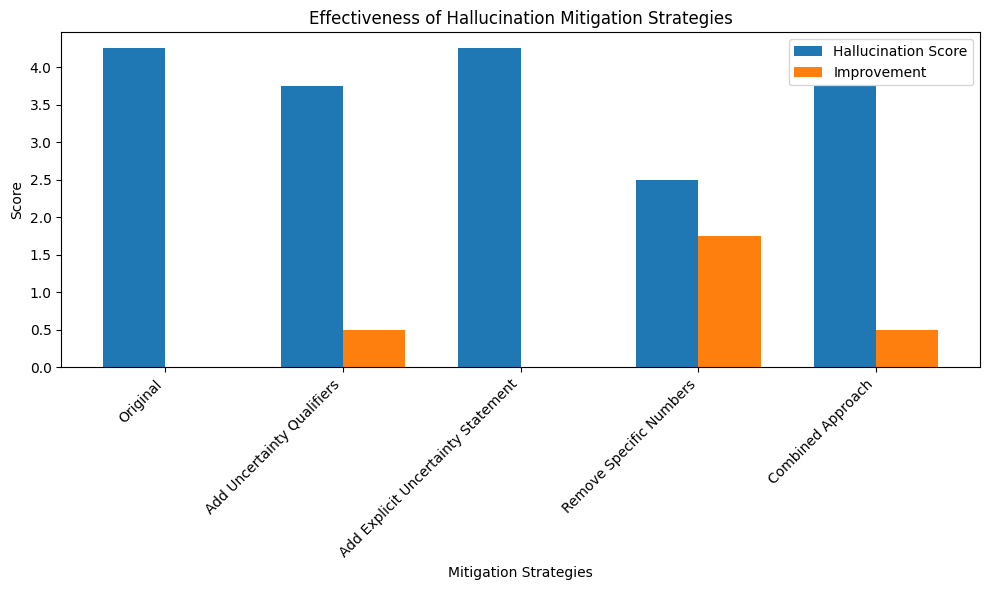

Hallucination Mitigation Results:

Original:
- Score: 4.25
- Improvement: 0.00
- Remaining issues:
  * Definitive claim detected: '100% effective'
  * Definitive claim detected: 'All patients'
  * Specific unverifiable statistic: '87% of patients'
  * Unverifiable claim: 'It is well established'
  * Medical advice detected: 'You should'

Add Uncertainty Qualifiers:
- Score: 3.75
- Improvement: 0.50
- Remaining issues:
  * Definitive claim detected: '100% effective'
  * Definitive claim detected: 'All patients'
  * Specific unverifiable statistic: '87% of patients'
  * Medical advice detected: 'You should'

Add Explicit Uncertainty Statement:
- Score: 4.25
- Improvement: 0.00
- Remaining issues:
  * Definitive claim detected: '100% effective'
  * Definitive claim detected: 'All patients'
  * Specific unverifiable statistic: '87% of patients'
  * Unverifiable claim: 'It is well established'
  * Medical advice detected: 'You should'

Remove Specific Numbers:
- Score: 2.50
- Improvement: 1

In [8]:
# Cell 8: Hallucination mitigation strategies
def test_mitigation_strategies(response_with_hallucination):
    """Test different hallucination mitigation strategies on a sample response"""
    # Original response with hallucination
    original_score = detect_hallucinations(response_with_hallucination, "")["score"]
    
    # Strategy 1: Add uncertainty qualifiers
    uncertainty_qualifiers = [
        (r"(is|are) (\w+)", r"may be \2"),
        (r"will (\w+)", r"may \1"),
        (r"always", r"often"),
        (r"never", r"rarely"),
        (r"(\d+)%", r"approximately \1%"),
        (r"all patients", r"many patients"),
        (r"everyone", r"many people")
    ]
    
    mitigated_response1 = response_with_hallucination
    for pattern, replacement in uncertainty_qualifiers:
        mitigated_response1 = re.sub(pattern, replacement, mitigated_response1)
    
    # Strategy 2: Add explicit uncertainty statements
    uncertainty_statement = "\n\nPlease note that medical knowledge is constantly evolving, and individual cases may vary. The information provided is based on general medical understanding."
    mitigated_response2 = response_with_hallucination + uncertainty_statement
    
    # Strategy 3: Remove specific numbers
    number_patterns = [
        r"\d{2,3}% of (patients|people|cases)",
        r"(\d{2,3})% effective",
        r"(\d+) out of (\d+) (patients|people|cases)"
    ]
    
    mitigated_response3 = response_with_hallucination
    for pattern in number_patterns:
        mitigated_response3 = re.sub(pattern, "some", mitigated_response3)
    
    # Strategy 4: Combine strategies 1 and 2
    mitigated_response4 = mitigated_response1 + uncertainty_statement
    
    # Evaluate each strategy
    strategies = {
        "Original": response_with_hallucination,
        "Add Uncertainty Qualifiers": mitigated_response1,
        "Add Explicit Uncertainty Statement": mitigated_response2,
        "Remove Specific Numbers": mitigated_response3,
        "Combined Approach": mitigated_response4
    }
    
    results = {}
    for name, response in strategies.items():
        hallucination_check = detect_hallucinations(response, "")
        results[name] = {
            "score": hallucination_check["score"],
            "issues": hallucination_check["issues"],
            "improvement": original_score - hallucination_check["score"]
        }
    
    return results

# Sample response with hallucination for testing
sample_hallucination = """
Studies show that 87% of patients with these symptoms have diabetes. It is well established that taking vitamin C will always prevent complications. You should take 500mg of vitamin D daily to manage your condition. All patients with diabetes experience the same symptoms, and treatment is 100% effective if started early.
"""

# Test mitigation strategies
mitigation_results = test_mitigation_strategies(sample_hallucination)

# Visualize mitigation results
plt.figure(figsize=(10, 6))

strategies = list(mitigation_results.keys())
scores = [mitigation_results[s]["score"] for s in strategies]
improvements = [mitigation_results[s]["improvement"] for s in strategies]

x = np.arange(len(strategies))
width = 0.35

plt.bar(x - width/2, scores, width, label='Hallucination Score')
plt.bar(x + width/2, improvements, width, label='Improvement')

plt.xlabel('Mitigation Strategies')
plt.ylabel('Score')
plt.title('Effectiveness of Hallucination Mitigation Strategies')
plt.xticks(x, strategies, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.savefig("evaluation/mitigation_strategies.png")
plt.show()

# Display detailed results
print("Hallucination Mitigation Results:")
for strategy, result in mitigation_results.items():
    print(f"\n{strategy}:")
    print(f"- Score: {result['score']:.2f}")
    print(f"- Improvement: {result['improvement']:.2f}")
    if result["issues"]:
        print("- Remaining issues:")
        for issue in result["issues"]:
            print(f"  * {issue}")


## Hallucination Log Generation

In [9]:
# Cell 9: Generate hallucination log
def generate_hallucination_log(results, mitigation_results):
    """Generate a comprehensive hallucination log with examples and mitigation strategies"""
    log = """# Medical QA System Hallucination Log

This document catalogs examples of hallucinations detected during evaluation and provides strategies to mitigate them.

## Common Hallucination Types

"""
    
    # Add hallucination types
    issue_types = analyze_hallucination_issues(results)
    for issue_type, count in issue_types.items():
        if count > 0:
            log += f"### {issue_type}\n\n"
            
            # Add examples
            examples = []
            for hallucination in results["hallucinations"]:
                for issue in hallucination["issues"]:
                    if issue_type in issue:
                        examples.append({
                            "query": hallucination["query"],
                            "issue": issue,
                            "response_excerpt": hallucination["response_excerpt"]
                        })
            
            if examples:
                example = examples[0]  # Just use the first example
                log += f"**Example:** *\"{example['response_excerpt']}\"*\n\n"
                log += f"**Issue:** {example['issue']}\n\n"
            
            # Add mitigation strategies
            log += "**Mitigation:**\n"
            if issue_type == "Definitive claim":
                log += "- Use qualifying language: \"may help,\" \"some studies suggest,\" \"evidence indicates\"\n"
                log += "- Express appropriate uncertainty: \"while research is ongoing,\" \"results are mixed\"\n"
                log += "- Include context about evidence quality: \"small studies have shown,\" \"large clinical trials have demonstrated\"\n"
            elif issue_type == "Specific unverifiable statistic":
                log += "- Use ranges instead of specific percentages\n"
                log += "- Qualify with \"approximately\" or \"roughly\"\n"
                log += "- Only include statistics that are widely accepted in medical literature\n"
                log += "- Avoid citing specific studies without proper attribution\n"
            elif issue_type == "Unverifiable claim":
                log += "- Cite specific, reputable sources when making claims\n"
                log += "- Use phrases like \"according to\" or \"some research suggests\"\n"
                log += "- Avoid sweeping generalizations about medical consensus\n"
                log += "- Acknowledge areas of ongoing research or debate\n"
            elif issue_type == "Medical advice":
                log += "- Reframe as general information: \"This medication is typically prescribed as...\"\n"
                log += "- Include disclaimers: \"A healthcare provider determines appropriate dosing\"\n"
                log += "- Focus on explaining mechanisms rather than making recommendations\n"
                log += "- Use phrases like \"commonly,\" \"generally,\" or \"typically\" rather than directives\n"
            elif issue_type == "Low concept coverage":
                log += "- Ensure responses cover key medical concepts related to the query\n"
                log += "- Include comprehensive information about symptoms, causes, and treatments\n"
                log += "- Structure responses to systematically address different aspects of the medical topic\n"
                log += "- Use medical terminology appropriately while providing explanations\n"
            
            log += "\n"
    
    log += """## Hallucination Reduction Strategies

Based on our evaluation, the following strategies are effective at reducing hallucinations in medical responses:

"""
    
    # Add mitigation strategies from testing
    strategies_by_effectiveness = sorted(
        mitigation_results.items(), 
        key=lambda x: x[1]["improvement"], 
        reverse=True
    )
    
    for i, (strategy, result) in enumerate(strategies_by_effectiveness):
        if strategy != "Original" and result["improvement"] > 0:
            log += f"### {i}. {strategy}\n\n"
            log += f"**Effectiveness:** Reduces hallucination score by {result['improvement']:.2f} points\n\n"
            
            if strategy == "Add Uncertainty Qualifiers":
                log += "**Implementation:**\n"
                log += "- Replace definitive statements with qualified language\n"
                log += "- Change \"is/are\" to \"may be\"\n"
                log += "- Change \"will\" to \"may\"\n"
                log += "- Replace \"always\" with \"often\"\n"
                log += "- Replace \"never\" with \"rarely\"\n"
                log += "- Add qualifiers to statistics: \"approximately X%\"\n"
            elif strategy == "Add Explicit Uncertainty Statement":
                log += "**Implementation:**\n"
                log += "- Add a standard disclaimer about medical knowledge limitations\n"
                log += "- Acknowledge that individual cases may vary\n"
                log += "- Clarify that information is based on general understanding\n"
                log += "- Reinforce the importance of professional medical consultation\n"
            elif strategy == "Remove Specific Numbers":
                log += "**Implementation:**\n"
                log += "- Replace specific percentages with qualitative terms\n"
                log += "- Use \"some,\" \"many,\" or \"most\" instead of exact numbers\n"
                log += "- Avoid precise statistics unless well-established\n"
                log += "- Focus on trends and patterns rather than specific figures\n"
            elif strategy == "Combined Approach":
                log += "**Implementation:**\n"
                log += "- Apply multiple mitigation strategies simultaneously\n"
                log += "- Use qualified language throughout the response\n"
                log += "- Add explicit uncertainty statements\n"
                log += "- Remove or qualify specific numbers\n"
                log += "- Include appropriate medical disclaimers\n"
            
            log += "\n**Example Before:**\n"
            log += f"

SyntaxError: unterminated string literal (detected at line 110) (3653755346.py, line 110)